In [1]:
from SPCCT_4D import Sample, Timepoint, Viewer, vesselDiameter

# Calling the bunny army

s1 = Sample("1")
s2 = Sample("2")
s3 = Sample("3")
s4 = Sample("4")
#s6 = Sample("6")
#s7 = Sample("7")
#s9 = Sample("9")
#s10 = Sample("10")

# missing 10 min for analyses
#s5 = Sample(5)
#s8 = Sample(8) this is actually decale so no time 7 but the series are offset to the left

# Dotarem data (HU)

#d1 = Sample("dotarem1")
#d2 = Sample("dotarem2")
#d3 = Sample("dotarem3")
#d4 = Sample("dotarem4")
#d5 = Sample("dotarem5")
#d6 = Sample("dotarem6")

Available directories:
0: 2021_01_25.4531.300.2024_03_17.AGUIX_Rabbit_26201_h00000
1: 2021_01_25.4531.400.2024_03_15.AGUIX_Rabbit_26201_f00001
2: 2021_01_25.4531.500.2024_03_15.AGUIX_Rabbit_26201_f00002
3: 2021_01_25.4531.600.2024_03_15.AGUIX_Rabbit_26201_f00003
4: 2021_01_25.4531.700.2024_03_15.AGUIX_Rabbit_26201_f00004
Conventional file 1 total DICOM files found: 480
Spectral\k_gadolinium file 1 total DICOM files found: 480
Conventional file 2 total DICOM files found: 480
Spectral\k_gadolinium file 2 total DICOM files found: 480
Conventional file 3 total DICOM files found: 480
Spectral\k_gadolinium file 3 total DICOM files found: 480
Conventional file 4 total DICOM files found: 480
Spectral\k_gadolinium file 4 total DICOM files found: 480
Conventional file 5 total DICOM files found: 480
Spectral\k_gadolinium file 5 total DICOM files found: 480
Available directories:
0: 2021_01_25.4533.300.2024_03_17.AGUIX_Rabbit_26608_e00000
1: 2021_01_25.4533.400.2024_03_15.AGUIX_Rabbit_26608_c00001

In [ ]:
# Look at dicom metadata
import pydicom
file_path = "D://copyRaw//Rabbit_AGUIX_1//2021_01_25.4531.500.2024_03_15.AGUIX_Rabbit_26201_f00002//Conventional//dcm//0294.dcm"

#file_path = "D://copyRaw//Rabbit_AGUIX_dotarem1//2021_01_18.4500.500.2021_01_22.RABJAN00017//Conventional//dcm//0240.dcm"
medical_image = pydicom.read_file(file_path)
print(medical_image)

print(d1.acquisition[1].kedge)

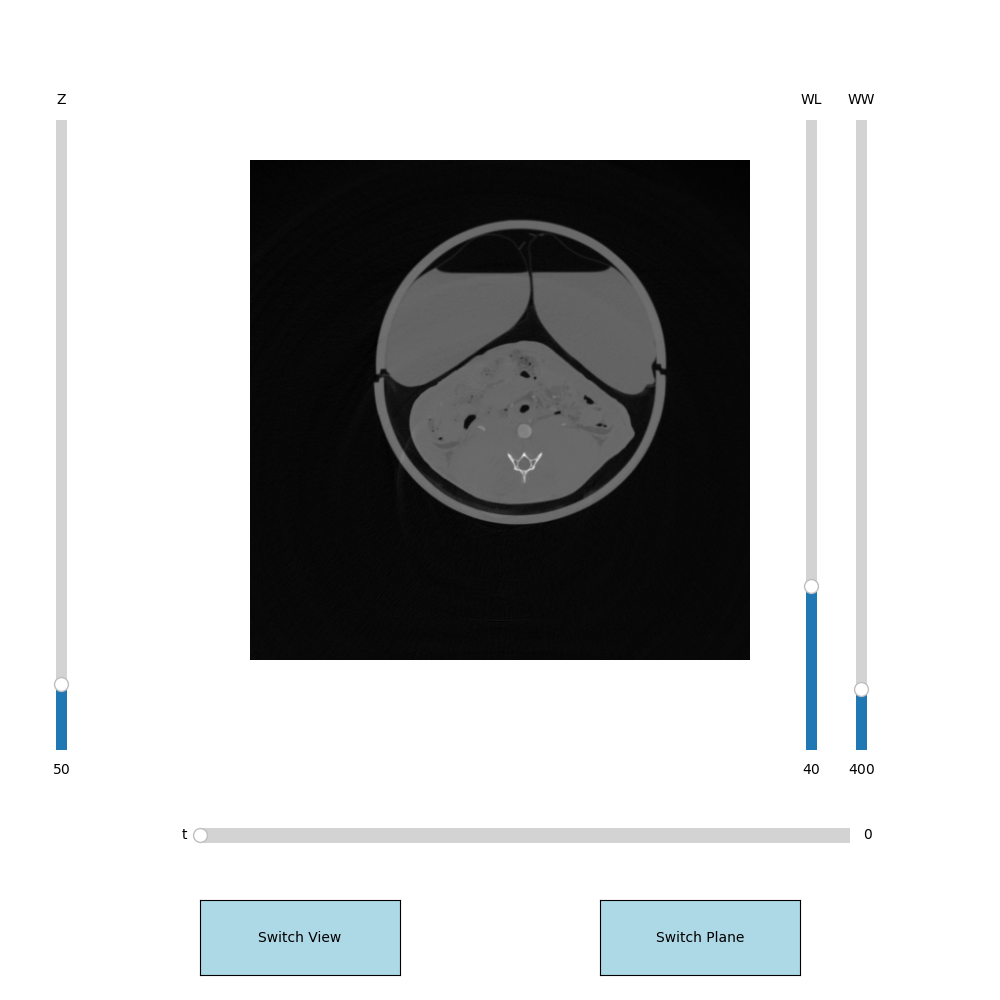

In [3]:
%matplotlib widget
viewS4 = Viewer(s6)


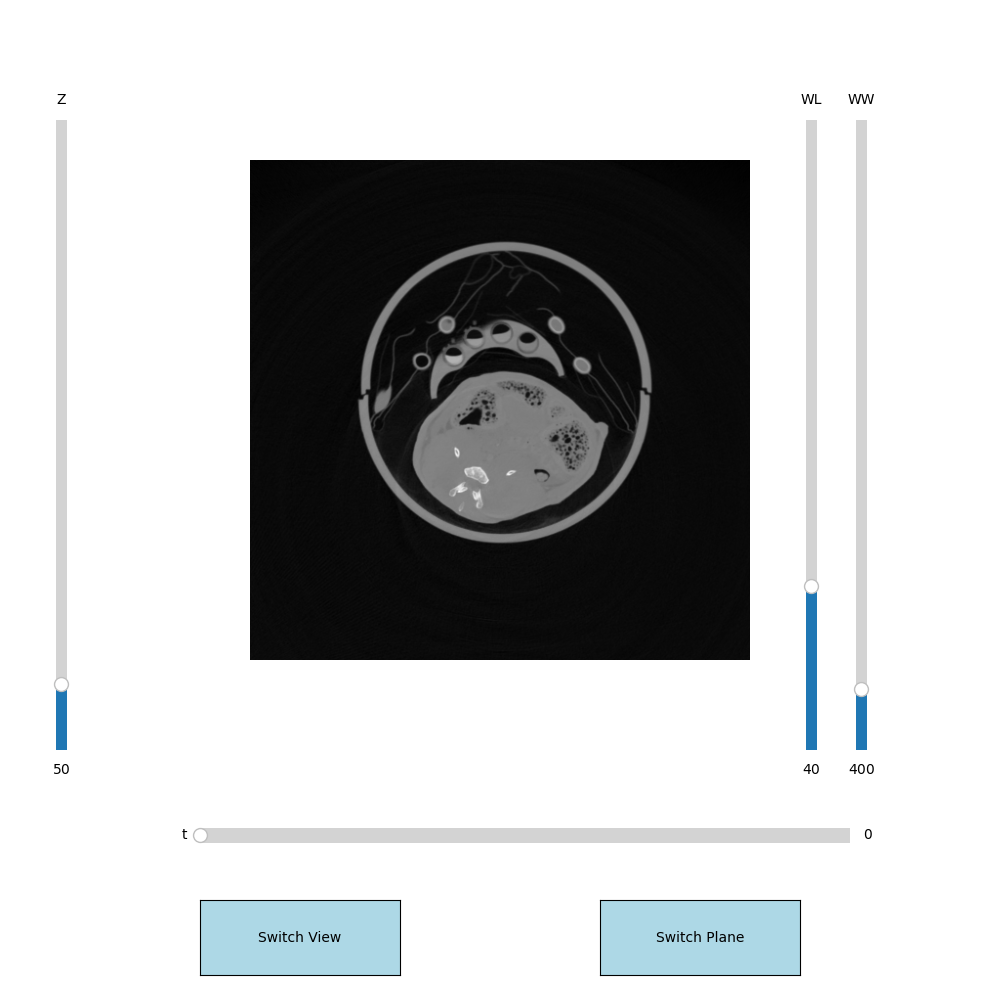

Processing the selection...
179
   Signal_HU   Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0  54.129032  63.976608 -0.246857      0.121935     0.359532  -0.425016
1  36.354839  47.742690 -0.604775      0.383871     0.288187   1.046572
2  42.451613  54.350877 -0.546697      0.174194     0.217778  -0.344441
3  24.806452  42.157895 -0.636433      0.116774     0.123509  -0.047990
4  50.354839  53.871345 -0.246427      0.198065     0.133099   0.849080


c:\Users\Chris\OneDrive\2023\BME_M2\STAGE\Thesis\Scripts_and_venv\internship_M2\SPCCT_4D.py:335: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


In [15]:
from SPCCT_4D import vesselDiameter
%matplotlib widget

#Manual segmentations
#d3 = Sample("dotarem3")
samp = s1
# Load previously made mask to evaluate quality
#vesselDiameter(samp, "Masks\\IVC_s4_292_t1.npy")
#vesselDiameter(samp, "Vessel_Masks\\IRVC_s1_297.npy")

#vesselDiameter(samp, "Kidney_Masks\\r_cortex_d3_143.npy")

vesselDiameter(samp, None)


10.770329614269007


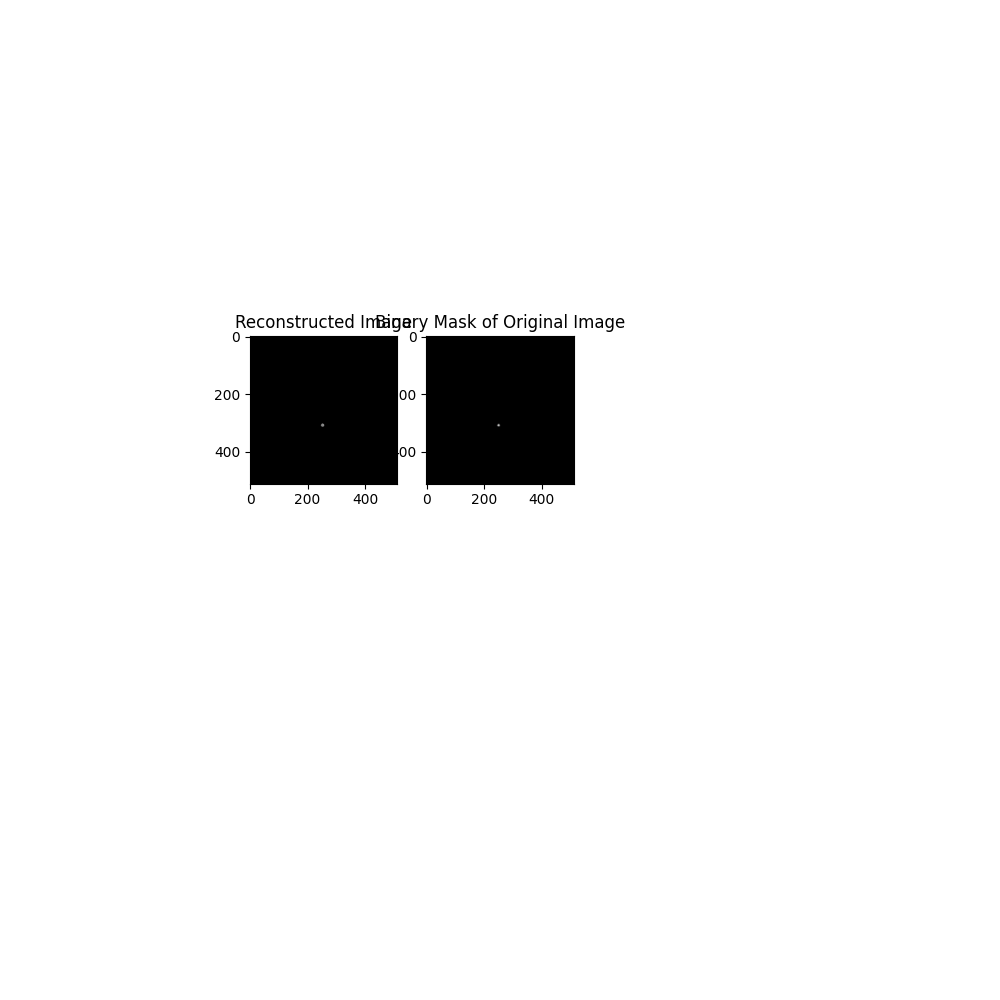

(131, 2)


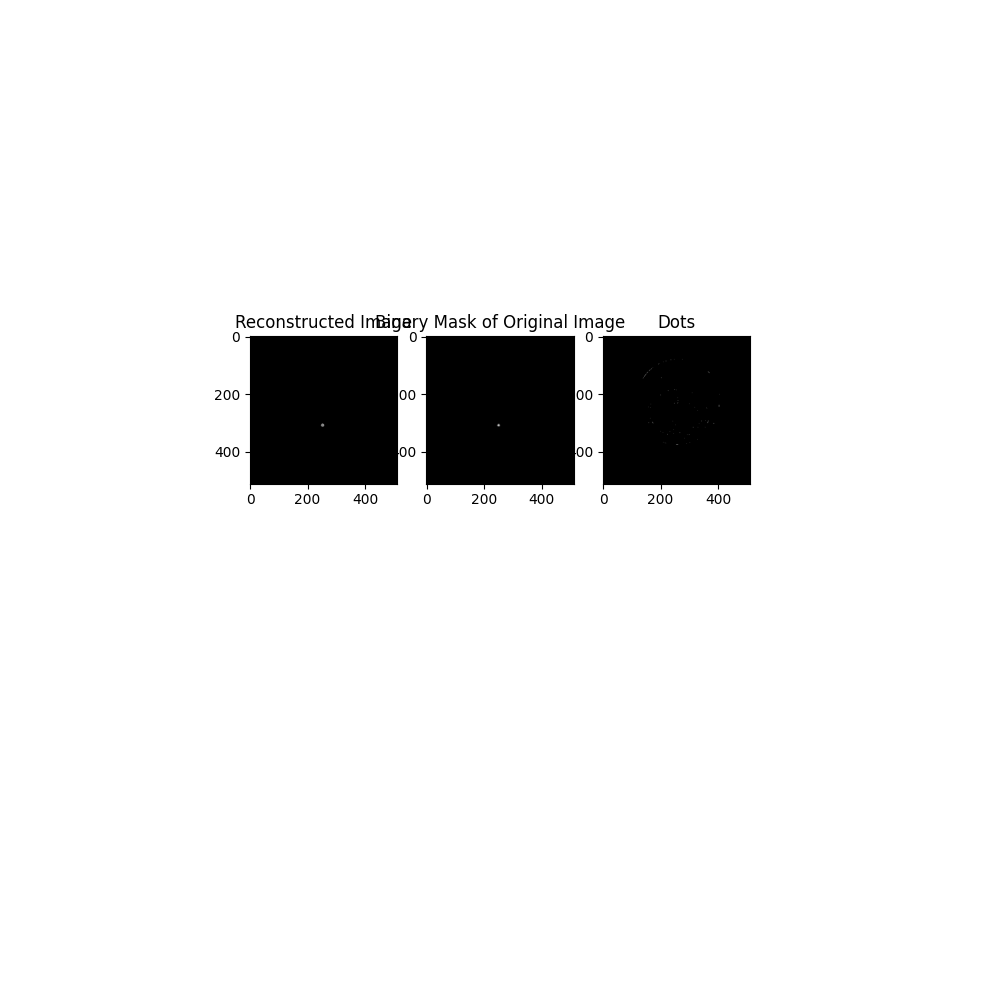

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology as MM
import scipy.ndimage as ndi

start = s1.acquisition[1].conventional[:,:,459]
start_mask = np.load("Masks\\SAA_s1_459.npy")

stop = s1.acquisition[1].conventional[:,:,241]
stop_mask = np.load("Masks\\IRA_s1_241.npy")

#start_mask = np.all(start_mask == [1, 0, 0, 0.5], axis=-1)
#start_mask = start_mask.astype(int)

#stop_mask = np.all(stop_mask == [1, 0, 0, 0.5], axis=-1)
#stop_mask = stop_mask.astype(int)

def greyscale_mask(mask):
    to3D = np.all(mask == [1,0,0,0.5], axis = -1)
    to3D = to3D.astype(int)
    return to3D

def generate_marker_from_coords(shape, coordinates):
    marker = np.zeros(shape)
    marker[coordinates[:, 0], coordinates[:, 1]] = True
    return marker

#edt = ndi.distance_transform_edt(to3D)
    #maxima = MM.h_maxima(edt, 2)
    #coordinates = np.where(maxima == 1)
    #print(coordinates[0])
    #coordinates = np.asarray(coordinates).T
    #print(coordinates[0])
plt.clf()
plt.subplot(1, 3, 1)
plt.imshow(greyscale_mask(start_mask)*start, cmap='gray')
plt.title("Reconstructed Image")

nxt = s1.acquisition[1].conventional[:,:,458]
binary_start = nxt > np.percentile(nxt, 95)
edt = ndi.distance_transform_edt(binary_start)

coords = MM.h_maxima(edt, 2)
coordinates = np.where(coords == 1)
coordinates = np.asarray(coordinates).T

dotplot = generate_marker_from_coords(start.shape, coordinates)

edt = ndi.distance_transform_edt(greyscale_mask(start_mask))
radius = np.max(edt)
print(radius*2)

plt.subplot(1, 3, 2)
plt.imshow(edt, cmap='gray')
plt.title("Binary Mask of Original Image")
plt.show()
print(coordinates.shape)

plt.subplot(1,3,3)
plt.imshow(dotplot, cmap = "gray")
plt.title("Dots")
plt.show()




In [ ]:
# vessel3D class(self, sample, list of mask strings (n=2))

# function that determines and stores centroid coordinates of manually segmented masks at the appropriate slice of the 3d stack

# function that takes the next slice and performs a euclidean distance transform and a hmaxima to extract the coordinates of maxima in my images
# it should compare the current slice iteration to the previous slice and choose the maxima that has the lowest distance

